# 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
import torchvision.utils as vutils
import pytorch_lightning as pl
import torchmetrics
import wandb

from torchvision.models import resnet18, ResNet18_Weights
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import random_split
from torchinfo import summary
from torch import nn, optim

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

C:\Users\ufuks\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ufuksecilmis. Use `wandb login --relogin` to force relogin


True

# 2. Select Device

In [3]:
has_gpu = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print(f"Target device is {device}")


# Some hyperparameters
random_seed = 1
batch_size = 64
learning_rate = 1e-3
num_epochs = 2
num_classes = 2
image_width,image_height = (224,224)

GPU is available
Target device is cuda


**Change the batch_size and compare the performance**

In [4]:
training_data_dir   = 'C:\\Users\\ufuks\\Documents\\Master\\hymenoptera_data\\hymenoptera_data\\train\\'
test_data_dir       = 'C:\\Users\\ufuks\\Documents\\Master\\hymenoptera_data\\hymenoptera_data\\val\\'

In [5]:
train_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.AutoAugment(transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

test_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),                   
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
    ])

**There is no difference in performance with/without transforms.Nornmalize**

In [6]:
train_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.AutoAugment(transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
    torchvision.transforms.ToTensor()
    ])

test_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),                   
    torchvision.transforms.ToTensor()                
    ])

In [7]:
# ImageFolder
train_dataset = ImageFolder(training_data_dir,transform = train_data_transform)
test_dataset =  ImageFolder(test_data_dir,transform = test_data_transform)

In [8]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=3,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([64, 3, 224, 224])


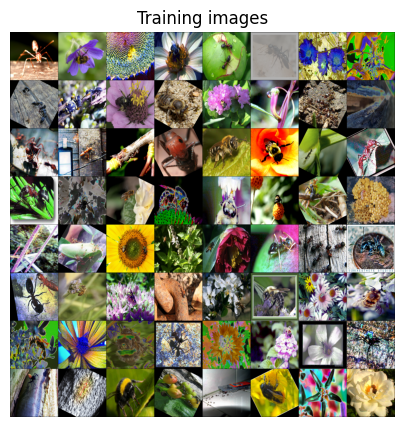

Labels = 
[[0 1 1 1 0 0 1 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 0 1 1 0 0]
 [0 1 1 1 1 1 0 1]
 [0 0 1 1 1 0 0 0]
 [0 1 1 0 1 1 1 1]
 [1 1 1 0 1 1 1 0]
 [0 0 1 0 0 1 0 1]]


In [9]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1].data.numpy().reshape(8,8))

In [10]:
class ResNet18(pl.LightningModule):
    def __init__(self, learning_rate, num_classes):
        
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)
        self.f1_macro = torchmetrics.F1Score(task="multiclass", num_classes = self.num_classes, average = 'macro')
        self.f1 = torchmetrics.F1Score(task="multiclass", num_classes = self.num_classes, average = 'none')
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Change the fully connected layer. I have 2 classes
        self.model.fc = torch.nn.Sequential(torch.nn.Linear(512, self.num_classes))
        
        
        self.save_hyperparameters()
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def _shared_step(self, batch):
        x , y = batch
        logits = self(x)

        loss = F.cross_entropy(logits, y)
        predicted_labels = torch.argmax(logits, dim=1)
        f1_macro = self.f1_macro(predicted_labels, y)
        f1 = self.f1(predicted_labels, y)
        return loss, y, predicted_labels, f1_macro, f1
    
    def training_step(self, batch, batch_idx):
        loss, y, predicted_labels, f1_macro, f1 = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, y)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, y, predicted_labels, f1_macro, f1 = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, y)
        self.log("val_acc", self.val_acc, prog_bar=True)
        self.log("val_f1_macro", f1_macro, on_epoch=True, sync_dist=True)
        self.log("val_f1_ant", f1[0], on_epoch=True, sync_dist=True)
        self.log("val_f1_bee", f1[1], on_epoch=True, sync_dist=True)
        return loss

    
    def test_step(self, batch, batch_idx):
        loss, y, predicted_labels, f1_macro, f1 = self._shared_step(batch)
        self.test_acc(predicted_labels, y)
        self.log("test_acc", self.test_acc)
        self.log("test_f1_macro", f1_macro, on_epoch=True, sync_dist=True)
        self.log("test_f1_ant", f1[0], on_epoch=True, sync_dist=True)
        self.log("test_f1_bee", f1[1], on_epoch=True, sync_dist=True)
        return loss
    
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [11]:
model = ResNet18(learning_rate = learning_rate, num_classes = num_classes)

# save top 1 model
checkpoint_callback = ModelCheckpoint(
    dirpath = 'C:\\Users\\ufuks\\Documents\\WSI\\Model\\Pytorch Tutorial\\Checkpoints_Ant_Bee\\',
    save_top_k=1,
    save_last = True,
    mode="max", monitor="val_f1_macro",
    filename="ResNet18-{epoch:02d}-{val_f1_macro:.4f}")


# initialise the wandb logger and name your wandb project
wandb_logger = WandbLogger(project='Ant_Bee_ResNet18')
wandb_logger.experiment.config["batch_size"] = batch_size



trainer = pl.Trainer(
                     accelerator = 'gpu', 
                     devices = -1, 
                     min_epochs = 1, 
                     max_epochs = 50, 
                     precision = 16,
                     callbacks=checkpoint_callback,
                     deterministic = True,
                     logger=wandb_logger
                     )

wandb_logger.watch(model)
trainer.fit(model, train_loader, test_loader)

C:\Users\ufuks\miniconda3\envs\torch\lib\site-packages\lightning_fabric\connector.py:555: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------

C:\Users\ufuks\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it, v_num=j01o]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, v_num=j01o, val_loss=2.500, val_acc=0.595, train_acc=0.651]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it, v_num=j01o, val_loss=9.880, val_acc=0.542, train_acc=0.818]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it, v_num=j01o, val_loss=3.160, val_acc=0.778, train_acc=0.854]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it, v_num=j01o, val_loss=15.50, val_acc=0.490, train_acc=0.901]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it, v_num=j01o, val_loss=4.430, val_acc=0.699, train_acc=0.885]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it, v_num=j01o, val_loss=1.870, val_acc=0.752, train_acc=0.891]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 

Epoch 31: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s, v_num=j01o, val_loss=0.365, val_acc=0.895, train_acc=0.990]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s, v_num=j01o, val_loss=0.363, val_acc=0.895, train_acc=0.995]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it, v_num=j01o, val_loss=0.357, val_acc=0.895, train_acc=0.995]
Validation: 0it [00:00, ?it/s]
Epoch 34: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s, v_num=j01o, val_loss=0.352, val_acc=0.895, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s, v_num=j01o, val_loss=0.353, val_acc=0.895, train_acc=0.990]
Validation: 0it [00:00, ?it/s]
Epoch 36: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s, v_num=j01o, val_loss=0.355, val_acc=0.895, train_acc=0.984]
Validation: 0it [00:00, ?it/s]
Epoch 37: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s, v_num=j01o, val_loss=0.356, val_acc=0.895, train_acc=1.000]
Va

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it, v_num=j01o, val_loss=0.365, val_acc=0.895, train_acc=0.979]


In [12]:
trainer.test(model, test_loader, 
             ckpt_path = 'C:\\Users\\ufuks\\Documents\\WSI\\Model\\Pytorch Tutorial\\Checkpoints_Ant_Bee\\ResNet18-epoch=17-val_f1_macro=0.6426.ckpt' )


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at C:\Users\ufuks\Documents\WSI\Model\Pytorch Tutorial\Checkpoints_Ant_Bee\ResNet18-epoch=17-val_f1_macro=0.6426.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\ufuks\Documents\WSI\Model\Pytorch Tutorial\Checkpoints_Ant_Bee\ResNet18-epoch=17-val_f1_macro=0.6426.ckpt


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9084967374801636     │
│        test_f1_ant        │    0.7287419438362122     │
│        test_f1_bee        │    0.5563853979110718     │
│       test_f1_macro       │    0.6425636410713196     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9084967374801636,
  'test_f1_macro': 0.6425636410713196,
  'test_f1_ant': 0.7287419438362122,
  'test_f1_bee': 0.5563853979110718}]

In [13]:
trainer.test(model, test_loader, 
             ckpt_path = 'C:\\Users\\ufuks\\Documents\\WSI\\Model\\Pytorch Tutorial\\Checkpoints_Ant_Bee\\last.ckpt' )


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at C:\Users\ufuks\Documents\WSI\Model\Pytorch Tutorial\Checkpoints_Ant_Bee\last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\ufuks\Documents\WSI\Model\Pytorch Tutorial\Checkpoints_Ant_Bee\last.ckpt


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  8.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8954248428344727     │
│        test_f1_ant        │    0.6765956282615662     │
│        test_f1_bee        │    0.5446743369102478     │
│       test_f1_macro       │     0.610634982585907     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8954248428344727,
  'test_f1_macro': 0.610634982585907,
  'test_f1_ant': 0.6765956282615662,
  'test_f1_bee': 0.5446743369102478}]

In [14]:

wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test_acc,█▁
test_f1_ant,█▁
test_f1_bee,█▁
test_f1_macro,█▁
train_acc,▁▄▅▆▆▆▆▇▇█▇▇███████▇███████████████▇████
train_loss,█▁▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▃▂▆▁▅▇▇▇▆▇▇▇████████████████████████████
val_f1_ant,▁▅▇▅▆▇▇▇▇▇▇▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_f1_bee,█▃█▁▆███████████████████████████████████


In [45]:
#trainer.validate(model, test_loader)
trainer.test(model, test_loader, 
             ckpt_path = 'C:\\Users\\ufuks\\Documents\\WSI\\Model\\Pytorch Tutorial\\Checkpoints_Ant_Bee\\ResNet18-epoch=19-val_f1_macro=0.5738.ckpt' )

wandb.finish()

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at C:\Users\ufuks\Documents\WSI\Model\Pytorch Tutorial\Checkpoints_Ant_Bee\ResNet18-epoch=19-val_f1_macro=0.5738.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\ufuks\Documents\WSI\Model\Pytorch Tutorial\Checkpoints_Ant_Bee\ResNet18-epoch=19-val_f1_macro=0.5738.ckpt


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.915032684803009     │
│        test_f1_ant        │    0.5906723737716675     │
│        test_f1_bee        │    0.5568825602531433     │
│       test_f1_macro       │     0.573777437210083     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_f1_ant,▁
test_f1_bee,▁
test_f1_macro,▁
train_acc,▁▂▁▂▃▃▄▅▆▆▆▇▇▇▇▇▇███████▇▇█▇█▇█████▇██▇█
train_loss,█▃▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▃▆▃▆▆▆▆▇▇▇█▇▇▇███▇█▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇
val_f1_ant,▆▁▇▁▆▆▆▇█▇▇██▇▇█████▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇█▇██
val_f1_bee,▁█▇████▆▇██▇██████▇▇▇▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
